In [124]:
# Install required packages
!pip install python-sat matplotlib numpy

# State.py

In [125]:
%%writefile state.py
class SudokuState:
    """
    Represents the configuration of the world (the Sudoku Grid).
    It encapsulates the data and the variable mapping logic.
    """
    def __init__(self, matrix=None):
        # 0 represents an empty cell, 1-9 represent values
        if matrix:
            self.grid = [row[:] for row in matrix] # Deep copy
        else:
            self.grid = [[0 for _ in range(9)] for _ in range(9)]

    def get_value(self, r, c):
        return self.grid[r][c]

    def set_value(self, r, c, val):
        self.grid[r][c] = val

    def variable_id(self, r, c, v):
        """
        Maps logic (row, col, value) to a unique integer ID for the SAT solver.
        Formula: ID = (row * 81) + (col * 9) + (val - 1) + 1
        Range: 1 to 729
        """
        return (r * 9 + c) * 9 + (v - 1) + 1

    @staticmethod
    def reverse_variable_id(var_id):
        """
        Maps a SAT variable ID back to (row, col, value).
        """
        adjusted = var_id - 1
        val = (adjusted % 9) + 1
        c = (adjusted // 9) % 9
        r = (adjusted // 81)
        return r, c, val

    def __str__(self):
        """
        Visualization of the state.
        """
        res = "-" * 25 + "\n"
        for i in range(9):
            line = "| "
            for j in range(9):
                val = self.grid[i][j]
                line += (str(val) if val != 0 else ".") + " "
                if (j + 1) % 3 == 0:
                    line += "| "
            res += line + "\n"
            if (i + 1) % 3 == 0:
                res += "-" * 25 + "\n"
        return res

Overwriting state.py


# Node.py

In [126]:
%%writefile node.py
from state import SudokuState

class Node:
    """
    A data structure that acts as a wrapper for the State.
    In a standard search, this tracks parent nodes and path costs.
    In this CSP context, it holds the current assignment configuration.
    """
    def __init__(self, state: SudokuState):
        self.state = state

    def get_state(self):
        return self.state

Overwriting node.py


# Problem.py

In [127]:
%%writefile problem.py
from node import Node
from state import SudokuState

class SudokuProblem:
    """
    Defines the Constraint Satisfaction Problem (CSP).
    It formulates the constraints as propositional logic sentences.
    """
    def __init__(self, initial_node: Node):
        self.initial_node = initial_node
        self.clauses = [] # The Knowledge Base (KB) in CNF

    def generate_constraints(self):
        """
        Generates all logic constraints for Sudoku.
        """
        self.clauses = [] # Reset

        # 1. Cell Constraints (Definedness & Uniqueness)
        self._add_cell_constraints()

        # 2. Line Constraints (Row & Column Uniqueness)
        self._add_line_constraints()

        # 3. Box Constraints (3x3 Sub-grid Uniqueness)
        self._add_box_constraints()

        # 4. Initial State Constraints (Prefilled values)
        self._add_initial_state_constraints()

        return self.clauses

    def _add_cell_constraints(self):
        """
        Logic: Each cell must contain exactly one number.
        1. Definedness: (X_rc1 v X_rc2 ... v X_rc9) -> At least one is True
        2. Uniqueness: (~X_rcj v ~X_rck) -> No two values can be True simultaneously
        """
        state = self.initial_node.get_state()
        for r in range(9):
            for c in range(9):
                # Definedness
                self.clauses.append([state.variable_id(r, c, v) for v in range(1, 10)])

                # Uniqueness
                for j in range(1, 10):
                    for k in range(j + 1, 10):
                        self.clauses.append([
                            -state.variable_id(r, c, j),
                            -state.variable_id(r, c, k)
                        ])

    def _add_line_constraints(self):
        """
        Logic: A value 'v' can appear at most once in a Row or Column.
        Constraint: (~X_r,c1,v v ~X_r,c2,v)
        """
        state = self.initial_node.get_state()
        for v in range(1, 10):
            # Row
            for r in range(9):
                for c1 in range(9):
                    for c2 in range(c1 + 1, 9):
                        self.clauses.append([
                            -state.variable_id(r, c1, v),
                            -state.variable_id(r, c2, v)
                        ])
            # Col
            for c in range(9):
                for r1 in range(9):
                    for r2 in range(r1 + 1, 9):
                        self.clauses.append([
                            -state.variable_id(r1, c, v),
                            -state.variable_id(r2, c, v)
                        ])

    def _add_box_constraints(self):
        """
        Logic: A value 'v' can appear at most once in a 3x3 Box.
        """
        state = self.initial_node.get_state()
        for v in range(1, 10):
            for br in range(0, 9, 3):
                for bc in range(0, 9, 3):
                    cells = []
                    for i in range(3):
                        for j in range(3):
                            cells.append((br + i, bc + j))

                    for i in range(len(cells)):
                        for j in range(i + 1, len(cells)):
                            r1, c1 = cells[i]
                            r2, c2 = cells[j]
                            self.clauses.append([
                                -state.variable_id(r1, c1, v),
                                -state.variable_id(r2, c2, v)
                            ])

    def _add_initial_state_constraints(self):
        """
        Logic: If the board starts with 5 at (0,0), then X_0,0,5 MUST be True.
        """
        state = self.initial_node.get_state()
        for r in range(9):
            for c in range(9):
                val = state.get_value(r, c)
                if val != 0:
                    self.clauses.append([state.variable_id(r, c, val)])

Overwriting problem.py


# Agent.py

In [128]:
%%writefile agent.py
from pysat.solvers import Glucose3
from state import SudokuState
from node import Node
from problem import SudokuProblem

class SudokuAgent:
    """
    The Intelligent Agent.
    1. Perceives input (Sudoku Matrix).
    2. Formulates Problem (CNF Clauses).
    3. Searches for solution (using Glucose3 solver).
    4. Acts (Returns the solved state).
    """
    def __init__(self):
        self.solver = Glucose3()

    def solve(self, input_matrix):
        # 1. Create State
        initial_state = SudokuState(input_matrix)

        # 2. Wrap in Node
        initial_node = Node(initial_state)

        # 3. Define Problem
        problem = SudokuProblem(initial_node)
        clauses = problem.generate_constraints()

        # 4. Load Solver
        for clause in clauses:
            self.solver.add_clause(clause)

        # 5. Execute Search
        is_sat = self.solver.solve()

        if not is_sat:
            self.solver.delete()
            return None

        # 6. Extract Solution (Model)
        model = self.solver.get_model()
        self.solver.delete()

        # 7. Map Model back to State
        solved_state = SudokuState() # Empty state
        for var_id in model:
            if var_id > 0:
                r, c, v = SudokuState.reverse_variable_id(var_id)
                solved_state.set_value(r, c, v)

        return solved_state

Overwriting agent.py


# Main.py

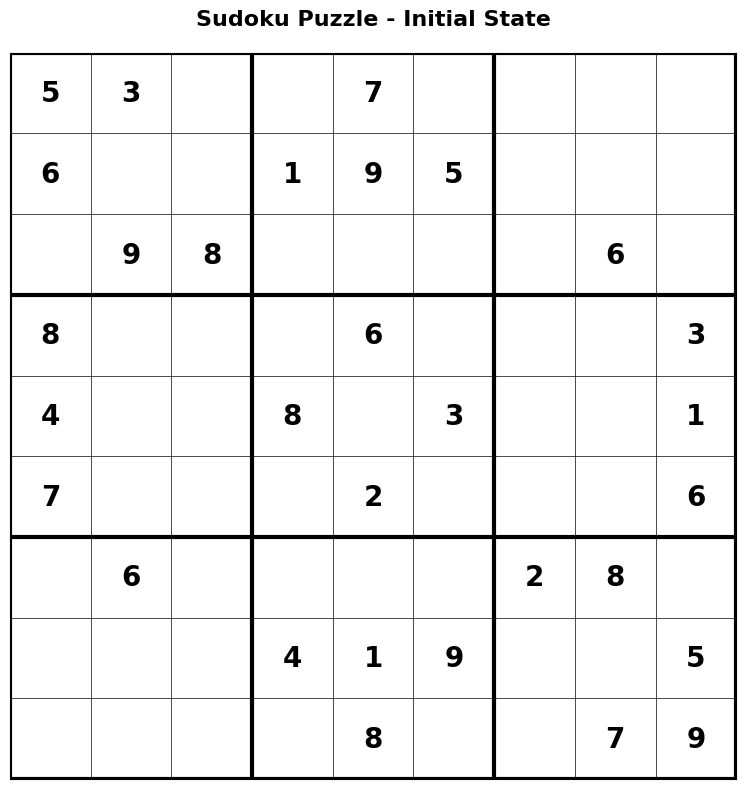


Solving the puzzle
Solution found in 0.0095 seconds. Creating visualization


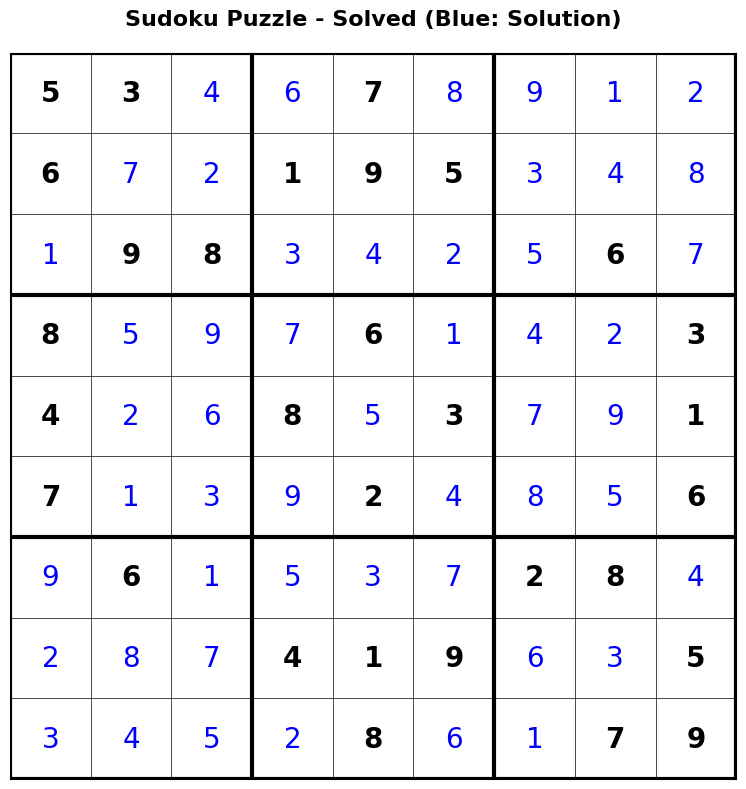

In [129]:
import matplotlib.pyplot as plt
from state import SudokuState
from agent import SudokuAgent
import time

def visualize_sudoku(puzzle, solution=None, title="Sudoku Puzzle"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    
    # Draw grid lines
    for i in range(10):
        linewidth = 3 if i % 3 == 0 else 0.5
        ax.plot([0, 9], [i, i], 'k-', linewidth=linewidth)
        ax.plot([i, i], [0, 9], 'k-', linewidth=linewidth)
    
    # Fill in numbers
    for r in range(9):
        for c in range(9):
            if puzzle[r][c] != 0:
                # Original puzzle numbers (bold black)
                ax.text(c + 0.5, r + 0.5, str(puzzle[r][c]),
                       ha='center', va='center', fontsize=20, 
                       fontweight='bold', color='black')
            elif solution and solution[r][c] != 0:
                # Solution numbers (blue)
                ax.text(c + 0.5, r + 0.5, str(solution[r][c]),
                       ha='center', va='center', fontsize=20, 
                       color='blue')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Visualize the puzzle
puzzle_input = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

fig = visualize_sudoku(puzzle_input, title="Sudoku Puzzle - Initial State")
plt.show()

print("\nSolving the puzzle")
input_state = SudokuState(puzzle_input)
agent = SudokuAgent()
start_time = time.time()
result_state = agent.solve(puzzle_input)
end_time = time.time()

if result_state:
    print(f"Solution found in {end_time - start_time:.4f} seconds. Creating visualization")
    fig = visualize_sudoku(puzzle_input, result_state.grid, 
                          title="Sudoku Puzzle - Solved (Blue: Solution)")
    plt.show()
else:
    print("No solution found.")